# Modules & Configuration

In [36]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import compute_class_weight
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from statistics import mean
from sklearn.model_selection import StratifiedKFold

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from collections import Counter
import multiprocessing

import os
import shutil
import tabnet

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [37]:
# Configuration

# Pandas
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", None)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.precision", 2)
pd.set_option('display.width', 1000)
pd.options.mode.chained_assignment = None

n_cpus = multiprocessing.cpu_count()

# Seaborn
sns.set()
color_blue = "#0089fa"
color_pink = "#ff0051"
colors = [color_blue, color_pink]
customPalette = sns.set_palette(sns.color_palette(colors))
customDiverging = sns.diverging_palette(207, 341, as_cmap=True)

# Avoid warnings
#warnings.filterwarnings('ignore')



print("Available CPUs: ", n_cpus)

Available CPUs:  16


In [38]:
class_names_complete = ['Sanos', 'Talasemias', 'Hemoglobinopatías', 'A.Ferropénicas', 'A.Crónico']

# Data Loading

In [39]:
#Load CSV fie
CBC_file_dir = "data/ProcessedData-2021-Filtrados.csv"
CBC = pd.read_csv(CBC_file_dir, error_bad_lines=True)
CBC["Clase"] = CBC["Clase"].astype(int)
print('File loaded, shape:(%s, %s)' %((len(CBC), len(CBC.iloc[0]))))

File loaded, shape:(3295, 18)


C:\Users\sergi\AppData\Local\Temp\ipykernel_27156\355433997.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  CBC = pd.read_csv(CBC_file_dir, error_bad_lines=True)


# Data Preprocessing

In [40]:
healthy = CBC.loc[CBC['Clase'] == 0]
thalassemias = CBC.loc[CBC['Clase'] == 1]
hemog = CBC.loc[CBC['Clase'] == 2]
anemiasferropenicas = CBC.loc[CBC['Clase'] == 3]
anemiastranscronico = CBC.loc[CBC['Clase'] == 4]

#Pick only specific thalassemias
#thalassemias = thalassemias.loc[(thalassemias['TipoClase'] == 7) | (thalassemias['TipoClase'] == 4) | (thalassemias['TipoClase'] == 3)]

CBC = pd.concat([healthy, hemog, anemiasferropenicas, anemiastranscronico, thalassemias])
print(CBC['Clase'].value_counts(sort=False))

0    863
2    798
3    455
4    504
1    675
Name: Clase, dtype: int64


In [41]:
CBC = CBC.sample(frac = 1)

labels = CBC['Clase']
CBC = CBC.drop('Clase', axis=1)
CBC = CBC.drop('TipoClase', axis=1)
df_columns = CBC.columns
CBC.replace(0,CBC.mean(axis=0),inplace=True)
CBC['Clase'] = labels

CBC['Clase'] = np.floor(pd.to_numeric(CBC['Clase'], errors='coerce')).astype('Int64')

In [42]:
print(df_columns)


Index(['Edad', 'WBC', 'LYAB', 'MOAB', 'NEAB', 'EO', 'BA', 'HEMA', 'HGB', 'HTO', 'VCM', 'MCH', 'CHCM', 'RDW', 'PLT', 'VPM'], dtype='object')


In [43]:
CBC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3295 entries, 2365 to 1601
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Edad    3295 non-null   float64
 1   WBC     3295 non-null   float64
 2   LYAB    3295 non-null   float64
 3   MOAB    3295 non-null   float64
 4   NEAB    3295 non-null   float64
 5   EO      3295 non-null   float64
 6   BA      3295 non-null   float64
 7   HEMA    3295 non-null   float64
 8   HGB     3295 non-null   float64
 9   HTO     3295 non-null   float64
 10  VCM     3295 non-null   float64
 11  MCH     3295 non-null   float64
 12  CHCM    3295 non-null   float64
 13  RDW     3295 non-null   float64
 14  PLT     3295 non-null   float64
 15  VPM     3295 non-null   float64
 16  Clase   3295 non-null   Int64  
dtypes: Int64(1), float64(16)
memory usage: 466.6 KB


In [44]:
print(CBC.describe())

           Edad       WBC      LYAB     MOAB      NEAB        EO       BA      HEMA      HGB      HTO      VCM       MCH      CHCM       RDW       PLT      VPM    Clase
count  3.30e+03  3.30e+03  3.30e+03  3295.00  3.30e+03  3.30e+03  3295.00  3.30e+03  3295.00  3295.00  3295.00  3.30e+03  3.30e+03  3.30e+03  3.30e+03  3295.00  3295.00
mean   5.41e-01  1.52e-01  6.94e-02     0.20  1.82e-01  8.66e-02     0.10  3.51e-01     0.51     0.46     0.41  4.00e-01  6.51e-01  1.58e-01  1.92e-01     0.39     1.72
std    2.27e-01  7.40e-02  5.62e-02     0.10  1.03e-01  8.30e-02     0.07  1.24e-01     0.13     0.13     0.14  1.49e-01  1.21e-01  1.10e-01  9.86e-02     0.14     1.39
min    9.80e-03  2.24e-03  3.30e-03     0.04  4.55e-03  2.86e-03     0.02  5.17e-03     0.12     0.07     0.03  6.56e-03  7.69e-03  3.42e-03  1.74e-03     0.06     0.00
25%    3.92e-01  1.05e-01  3.96e-02     0.14  1.18e-01  3.71e-02     0.07  2.59e-01     0.41     0.36     0.32  2.98e-01  5.92e-01  8.22e-02  1.33e-01     

# TabNet

In [45]:
BATCH_SIZE = 100

In [46]:
def transform(ds):
    labels = ds['Clase']
    ds.pop('Clase')
    
    x = ds
    y = tf.one_hot(labels, 5)
    return x, y

In [47]:
col_names = df_columns
print(len(col_names))

x_train, x_test, y_train, y_test = train_test_split(CBC, labels, test_size = 0.3, stratify=labels, shuffle=True)

ds_train = tf.data.Dataset.from_tensor_slices(x_train.to_dict(orient="list"))
ds_train = ds_train.map(transform)
ds_train = ds_train.batch(BATCH_SIZE)

ds_test = tf.data.Dataset.from_tensor_slices(x_test.to_dict(orient="list"))
ds_test = ds_test.map(transform)
ds_test = ds_test.batch(BATCH_SIZE)


16


In [48]:
feature_columns = []
for col_name in col_names:
    feature_columns.append(tf.feature_column.numeric_column(col_name))

In [49]:
model = tabnet.TabNetClassifier(feature_columns, num_classes=5,
                                feature_dim=17, output_dim=5,
                                num_decision_steps=1, relaxation_factor=1.0,
                                sparsity_coefficient=1e-5, batch_momentum=0.98,
                                virtual_batch_size=None, norm_type='group',
                                num_groups=1)

lr = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, decay_steps=1000, decay_rate=0.9, staircase=True)
optimizer = tf.keras.optimizers.Adam(lr)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

history = model.fit(ds_train, epochs=600, validation_data=ds_test, verbose=2, callbacks=[callback_es])

model.summary()

Epoch 1/600
24/24 - 1s - loss: 1.7605 - accuracy: 0.2042 - val_loss: 1.7370 - val_accuracy: 0.2032 - 1s/epoch - 58ms/step
Epoch 2/600
24/24 - 0s - loss: 1.7177 - accuracy: 0.2042 - val_loss: 1.6992 - val_accuracy: 0.2032 - 122ms/epoch - 5ms/step
Epoch 3/600
24/24 - 0s - loss: 1.6834 - accuracy: 0.2042 - val_loss: 1.6688 - val_accuracy: 0.2032 - 70ms/epoch - 3ms/step
Epoch 4/600
24/24 - 0s - loss: 1.6559 - accuracy: 0.2042 - val_loss: 1.6445 - val_accuracy: 0.2032 - 70ms/epoch - 3ms/step
Epoch 5/600
24/24 - 0s - loss: 1.6337 - accuracy: 0.2038 - val_loss: 1.6246 - val_accuracy: 0.2022 - 69ms/epoch - 3ms/step
Epoch 6/600
24/24 - 0s - loss: 1.6159 - accuracy: 0.2038 - val_loss: 1.6094 - val_accuracy: 0.2032 - 68ms/epoch - 3ms/step
Epoch 7/600
24/24 - 0s - loss: 1.6031 - accuracy: 0.2038 - val_loss: 1.5983 - val_accuracy: 0.2032 - 68ms/epoch - 3ms/step
Epoch 8/600
24/24 - 0s - loss: 1.5932 - accuracy: 0.2038 - val_loss: 1.5887 - val_accuracy: 0.2032 - 69ms/epoch - 3ms/step
Epoch 9/600
24/2

In [51]:
print()
if os.path.exists('logs/'):
    shutil.rmtree('logs/')

""" Save the images of the feature masks """
# Force eager execution mode to generate the masks
x, y = next(iter(ds_train))
_ = model(x)

writer = tf.summary.create_file_writer("logs/")
with writer.as_default():
    for i, mask in enumerate(model.tabnet.feature_selection_masks):
        print("Saving mask {} of shape {}".format(i + 1, mask.shape))
        tf.summary.image('mask_at_iter_{}'.format(i + 1), step=0, data=mask, max_outputs=1)
        writer.flush()

    agg_mask = model.tabnet.aggregate_feature_selection_mask
    print("Saving aggregate mask of shape", agg_mask.shape)
    tf.summary.image("Aggregate Mask", step=0, data=agg_mask, max_outputs=1)
    writer.flush()

writer.close()


Saving aggregate mask of shape (1, 100, 16, 1)


In [52]:
y_pred = np.argmax(model.predict(ds_test), axis=-1)
report = classification_report(y_test, y_pred)
print(report)

10/10 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.60      0.88      0.71       259
           1       0.72      0.73      0.72       203
           2       0.46      0.14      0.21       239
           3       0.53      0.71      0.61       137
           4       0.67      0.68      0.67       151

    accuracy                           0.61       989
   macro avg       0.60      0.63      0.59       989
weighted avg       0.59      0.61      0.57       989



Accuracy Y_test:  0.6137512639029322


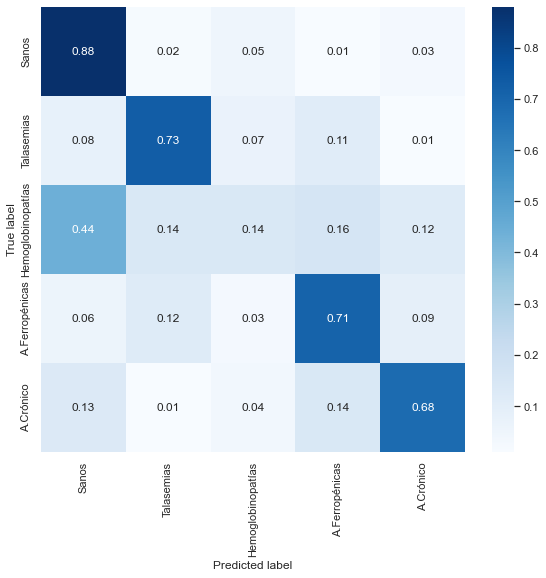

In [53]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float')/con_mat.sum(axis=1)[:, np.newaxis],
                         decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index=class_names_complete, columns=class_names_complete)

print('Accuracy Y_test: ', accuracy_score(y_test, y_pred))
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

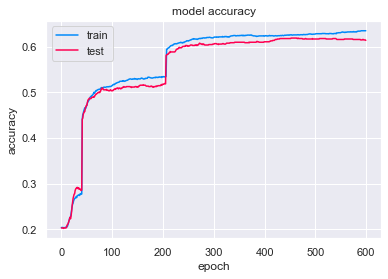

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

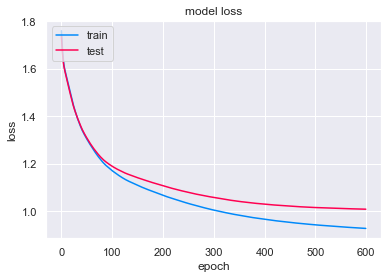

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()